# Advanced Neural Networks: Deep Learning for Spatial Analysis
# Assignment #1 - Object Classification Assignment: Diseased vs. Non-Diseased Leaf
# Rhichard Koh

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy
from torch.optim import lr_scheduler
import csv
from PIL import Image 

In [2]:
# Define data directories
train_dir = './training_set'
val_dir = './validation_set'
test_dir = './test_set'

# Data Transforms
data_transforms = { # Initializes a dictionary called data_transforms to store different transformation pipelines for training ('train'), validation ('val'), and testing ('test') datasets.
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # Randomly crops a portion of the image and resizes it to 224x224 pixels. 
        #This introduces randomness in the cropping process, which helps in data augmentation by providing varied perspectives of the images.
        transforms.RandomHorizontalFlip(), # Randomly flips the image horizontally with a default probability of 50%
        transforms.RandomRotation(40), # Randomly rotates the image by an angle between -40 and +40 degrees
        transforms.RandomAffine(0, shear=0.2, scale=(0.8, 1.2)), # Applies a random affine transformation with: 
        # Shear up to ±20%. Scaling between 80% and 120% of the original size.
        transforms.ColorJitter(brightness=0.2, contrast=0.2), # Randomly adjusts the brightness and contrast of the image. The adjustments are made within ±20% of the original values.
        transforms.ToTensor(), # Converts the image to a PyTorch tensor. Scales pixel intensity values from [0, 255] to [0.0, 1.0].
        transforms.Normalize([0.485, 0.456, 0.406],   # ImageNet mean
                             [0.229, 0.224, 0.225])   # ImageNet std
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), # Resizes the image so that the shorter side is 256 pixels, maintaining the aspect ratio.
        transforms.CenterCrop(224), # Crops out the central 224x224 pixels of the resized image.
        transforms.ToTensor(), # Converts the image to a PyTorch tensor. Scales pixel values to the range [0.0, 1.0].
        transforms.Normalize([0.485, 0.456, 0.406], # ImageNet mean
                             [0.229, 0.224, 0.225]) # ImageNet std
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Create Datasets
image_datasets = {
    # Creates image datasets using the hyperparameters stated in the data transforms dictionary.
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val'  : datasets.ImageFolder(val_dir, data_transforms['val']),
    'test' : datasets.ImageFolder(test_dir, data_transforms['test'])
}

# Create Data Loaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val'  : DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=4),
    'test' : DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
def show_images_with_labels(dataloader, class_names, num_images=16):
    # Get one batch of images and labels from the dataloader
    inputs, labels = next(iter(dataloader))
    # Move the inputs to CPU memory (if they are on GPU)
    inputs = inputs.cpu()
    # Move the labels to CPU memory (if they are on GPU)
    labels = labels.cpu()

    # Create a new figure with a size of 12x12 inches
    plt.figure(figsize=(12, 12))
    # Loop over the number of images to display
    for idx in range(num_images):
        # Add a subplot in a 4x4 grid at position idx+1
        ax = plt.subplot(4, 4, idx + 1)
        # Get the idx-th image from the inputs
        image = inputs[idx]

        # Unnormalize the image (reverse the normalization applied during preprocessing)
        # Define the mean used during normalization
        mean = np.array([0.485, 0.456, 0.406])
        # Define the standard deviation used during normalization
        std = np.array([0.229, 0.224, 0.225])
        # Convert the image tensor to a NumPy array and rearrange dimensions to (H, W, C)
        image = image.numpy().transpose((1, 2, 0))
        # Apply the inverse of normalization: multiply by std and add mean
        image = std * image + mean
        # Clip the pixel values to be between 0 and 1
        image = np.clip(image, 0, 1)

        # Display the image in the subplot
        plt.imshow(image)
        # Get the label for the current image
        label = labels[idx]
        # Retrieve the class name corresponding to the label
        class_name = class_names[label.item()]
        # Set the title of the subplot to the class name
        ax.set_title(class_name)
        # Hide the axis ticks and labels
        plt.axis('off')
    # Adjust the layout so that subplots fit into the figure area
    plt.tight_layout()
    # Display the figure
    plt.show()


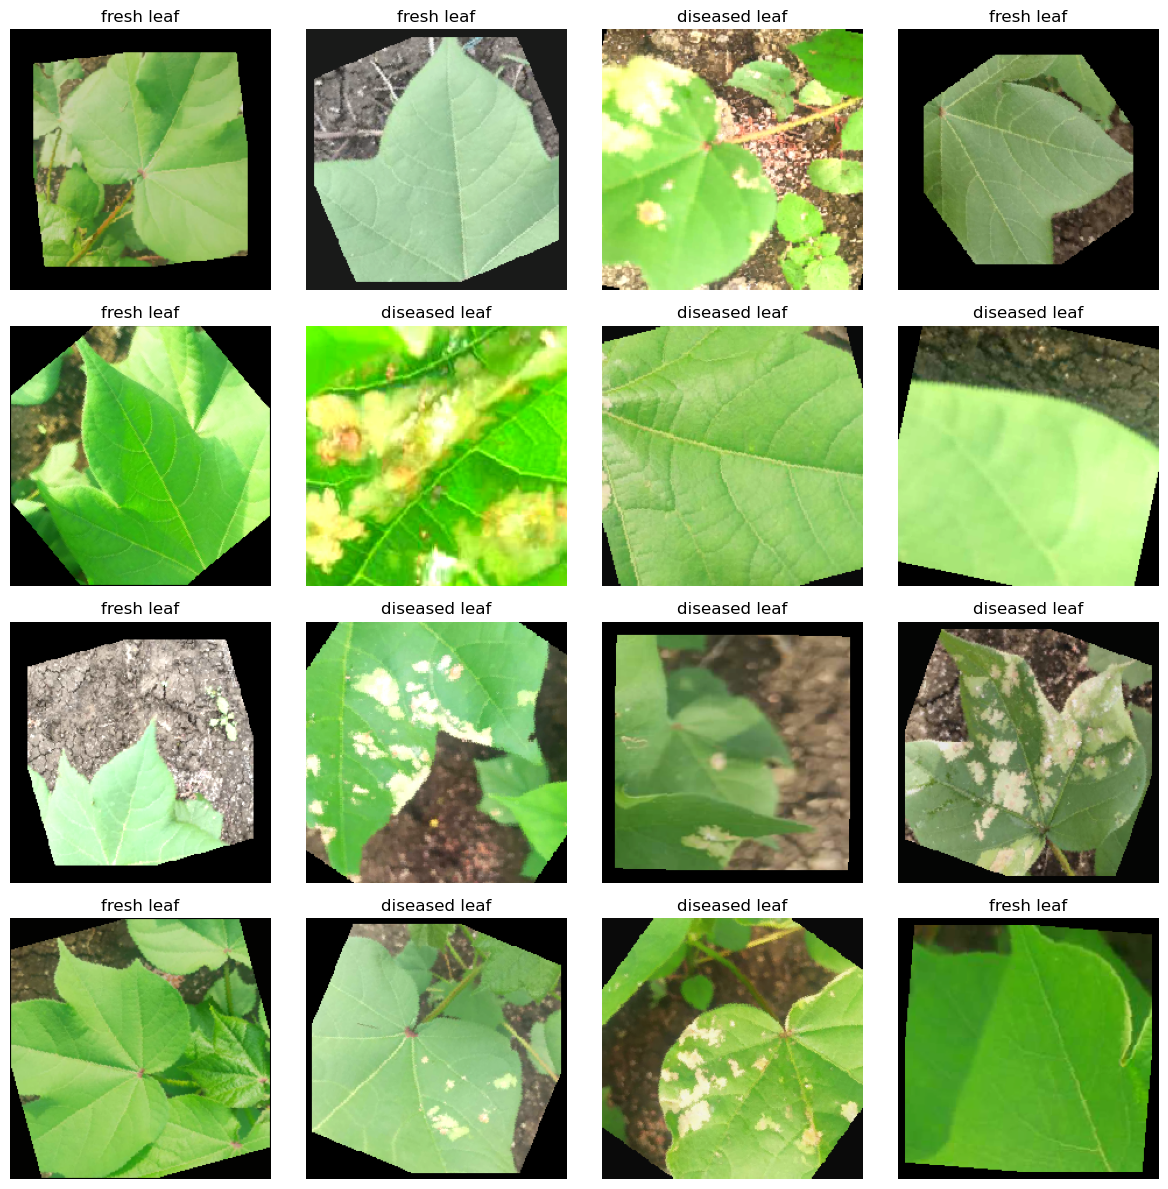

In [4]:
show_images_with_labels(dataloaders['train'], class_names, num_images=16)

In [5]:
# Load the pre-trained ResNet50 model with weights trained on ImageNet
model = models.resnet50(weights=True)

# Freeze all layers in the base model to prevent their weights from being updated during training
for param in model.parameters():
    param.requires_grad = False

# Get the number of input features for the original final fully connected layer
num_ftrs = model.fc.in_features

# Replace the final fully connected layer with a new fully connected layer for binary classification
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),  # Add a linear layer with 1024 output features
    nn.ReLU(),                  # Apply the ReLU activation function
    nn.Dropout(0.5),            # Add dropout with a probability of 0.5 to prevent overfitting
    nn.Linear(1024, 1),         # Add a linear layer that outputs a single value
    nn.Sigmoid()                # Apply the Sigmoid activation function to get a probability between 0 and 1
)

# Move the entire model to the specified device (GPU)
model = model.to(device)

c:\Users\xxryk\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

In [7]:
# Reduce LR on plateau
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-7)

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5, CSV_log=False):
    # Create a deep copy of the model's initial weights to save the best model later
    best_model_wts = copy.deepcopy(model.state_dict())
    # Initialize the best loss to positive infinity
    best_loss = float('inf')
    # Counter for epochs with no improvement to implement early stopping
    epochs_no_improve = 0

    # Lists to store the history of accuracy and loss for training and validation
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    # If CSV logging is enabled, create and write headers to the CSV file
    if CSV_log == True:
        with open("train_log.csv", mode='w') as file:
            writer = csv.writer(file)
            writer.writerow(['Phase', 'Epoch', 'Loss', 'Accuracy'])

    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        # Print the current epoch number
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training phase and a validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # Set the model to training mode
            else:
                model.eval()    # Set the model to evaluation mode

            # Initialize running loss and correct predictions for the current phase
            running_loss = 0.0
            running_corrects = 0

            # Iterate over the data in the current phase
            for inputs, labels in dataloaders[phase]:
                # Move inputs to the specified device (GPU)
                inputs = inputs.to(device)
                # Convert labels to float, add an extra dimension, and move to device
                labels = labels.float().unsqueeze(1).to(device)

                # Zero the gradients of the optimizer
                optimizer.zero_grad()

                # Forward pass (track gradients only if in training phase)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)       # Compute model outputs
                    preds = torch.round(outputs)  # Round outputs to get binary predictions (0 or 1)
                    loss = criterion(outputs, labels)  # Compute the loss

                    # Backward pass and optimization only in training phase
                    if phase == 'train':
                        loss.backward()   # Compute gradients
                        optimizer.step()  # Update model parameters

                # Accumulate loss and correct predictions
                running_loss += loss.item() * inputs.size(0)  # Multiply by batch size
                running_corrects += torch.sum(preds == labels.data)  # Count correct predictions

            # Compute average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Record loss and accuracy history
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.cpu().numpy())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.cpu().numpy())

            # If CSV logging is enabled, append the current epoch results to the CSV file
            if CSV_log == True:
                with open("train_log.csv", mode='a') as file:
                    writer = csv.writer(file)
                    writer.writerow([phase.capitalize(), epoch, float(epoch_loss), float(epoch_acc)])

            # Print the loss and accuracy for the current phase
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Check for improvement in validation loss
            if phase == 'val':
                # Update the learning rate scheduler based on validation loss
                scheduler.step(epoch_loss)

                # If the validation loss has decreased, save the model weights
                if epoch_loss < best_loss:
                    best_loss = epoch_loss  # Update the best loss
                    best_model_wts = copy.deepcopy(model.state_dict())  # Save best model weights
                    epochs_no_improve = 0  # Reset the counter for early stopping
                    torch.save(model.state_dict(), 'best_model.pth')  # Save the best model to a file
                else:
                    epochs_no_improve += 1  # Increment the counter
                    # If no improvement for 'patience' epochs, perform early stopping
                    if epochs_no_improve >= patience:
                        print('Early stopping!')
                        model.load_state_dict(best_model_wts)  # Load the best model weights
                        # Return the model and training history
                        return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history

    # After completing all epochs, load the best model weights
    print('Training complete')
    model.load_state_dict(best_model_wts)
    # Return the trained model and the history of accuracy and loss
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history


In [9]:
model, train_acc_history, val_acc_history, train_loss_history, val_loss_history = train_model(
    model, criterion, optimizer, scheduler, num_epochs=25, patience=5, CSV_log=True)

Epoch 1/25
----------
Train Loss: 0.5534 Acc: 0.7315
Val Loss: 0.4435 Acc: 0.9111
Epoch 2/25
----------
Train Loss: 0.3784 Acc: 0.8853
Val Loss: 0.3504 Acc: 0.8667
Epoch 3/25
----------
Train Loss: 0.3155 Acc: 0.9035
Val Loss: 0.2777 Acc: 0.9111
Epoch 4/25
----------
Train Loss: 0.2734 Acc: 0.9063
Val Loss: 0.2459 Acc: 0.9259
Epoch 5/25
----------
Train Loss: 0.2502 Acc: 0.9203
Val Loss: 0.2265 Acc: 0.9111
Epoch 6/25
----------
Train Loss: 0.2020 Acc: 0.9343
Val Loss: 0.2392 Acc: 0.9185
Epoch 7/25
----------
Train Loss: 0.2121 Acc: 0.9203
Val Loss: 0.2323 Acc: 0.9185
Epoch 8/25
----------
Train Loss: 0.1963 Acc: 0.9343
Val Loss: 0.2268 Acc: 0.9185
Epoch 9/25
----------
Train Loss: 0.1922 Acc: 0.9259
Val Loss: 0.2121 Acc: 0.9259
Epoch 10/25
----------
Train Loss: 0.2063 Acc: 0.9287
Val Loss: 0.2029 Acc: 0.9259
Epoch 11/25
----------
Train Loss: 0.1920 Acc: 0.9259
Val Loss: 0.1825 Acc: 0.9111
Epoch 12/25
----------
Train Loss: 0.2154 Acc: 0.9301
Val Loss: 0.1882 Acc: 0.9259
Epoch 13/25
-

Test Accuracy: 1.0
Precision Score: 1.0
Recall Score: 1.0
               precision    recall  f1-score   support

diseased leaf       1.00      1.00      1.00         3
   fresh leaf       1.00      1.00      1.00         5

     accuracy                           1.00         8
    macro avg       1.00      1.00      1.00         8
 weighted avg       1.00      1.00      1.00         8



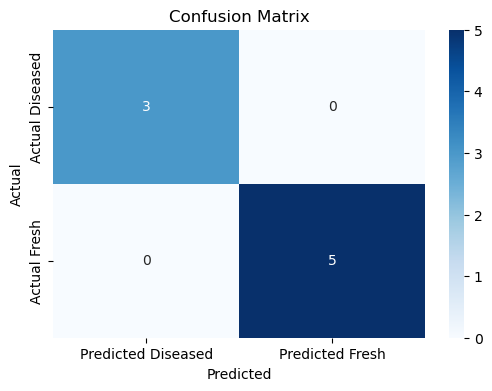

In [18]:
# Load the best model weights from the saved file 'best_model.pth'
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode (disables dropout and batch normalization layers)
model.eval()

# Initialize empty lists to store true labels and predicted labels
y_true = []
y_pred = []

# Disable gradient calculation for evaluation to save memory and computations
with torch.no_grad():
    # Iterate over the test dataset using the test dataloader
    for inputs, labels in dataloaders['test']:
        # Move the input tensors to the specified device (GPU)
        inputs = inputs.to(device)
        # Convert labels to float tensor, add an extra dimension, and move to device
        labels = labels.float().unsqueeze(1).to(device)

        # Perform a forward pass through the model to get outputs
        outputs = model(inputs)
        # Round the outputs to get binary predictions (0 or 1)
        preds = torch.round(outputs)

        # Append true labels to y_true list after moving them to CPU and converting to NumPy array
        y_true.extend(labels.cpu().numpy())
        # Append predicted labels to y_pred list after moving them to CPU and converting to NumPy array
        y_pred.extend(preds.cpu().numpy())

# Convert the lists of true labels and predicted labels to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate and print the accuracy, precision, and recall scores.
print(f"Test Accuracy: {accuracy_score(y_true,y_pred)}")
print(f"Precision Score: {precision_score(y_true,y_pred)}")
print(f"Recall Score: {recall_score(y_true,y_pred)}")

# Generate and print the classification report with precision, recall, and F1-score for each class
print(classification_report(y_true, y_pred, target_names=class_names))

# Compute the confusion matrix using the true and predicted labels
cm = confusion_matrix(y_true, y_pred)
# Create a new figure with a specified size for plotting
plt.figure(figsize=(6, 4))
# Plot the confusion matrix as a heatmap using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Diseased', 'Predicted Fresh'],
            yticklabels=['Actual Diseased', 'Actual Fresh'])
# Set the label for the y-axis
plt.ylabel('Actual')
# Set the label for the x-axis
plt.xlabel('Predicted')
# Set the title of the plot
plt.title('Confusion Matrix')
# Display the plotted confusion matrix
plt.show()

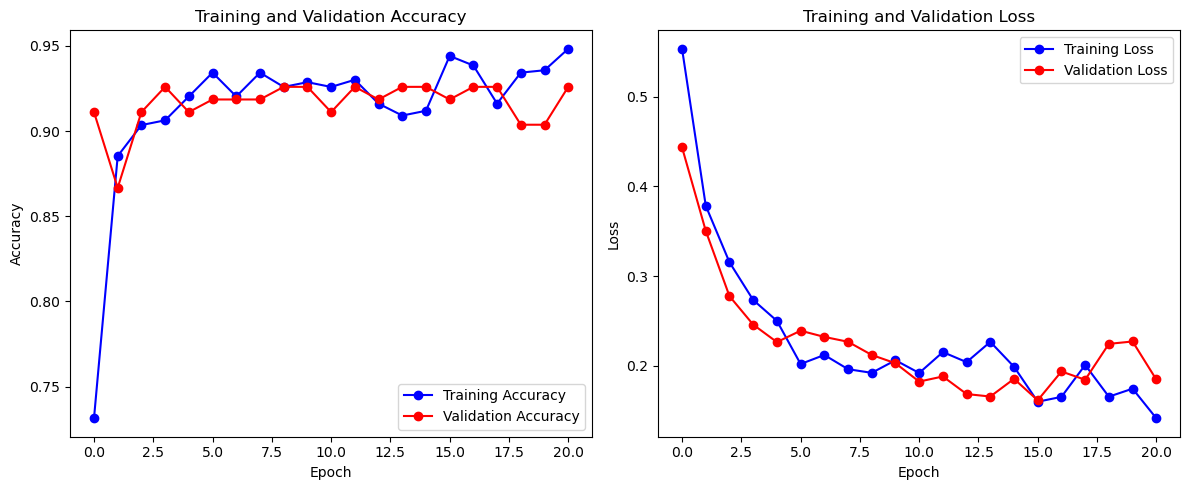

In [11]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc_history, 'bo-', label='Training Accuracy')
plt.plot(val_acc_history, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, 'bo-', label='Training Loss')
plt.plot(val_loss_history, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
def predict(model, dataloader):
    # Set the model to evaluation mode (disables dropout and batch normalization)
    model.eval()
    # Initialize empty lists to store predictions and true labels
    predictions = []
    true_labels = []
    
    # Disable gradient calculation for inference to reduce memory usage
    with torch.no_grad():
        # Iterate over batches in the dataloader
        for inputs, labels in dataloader:
            # Move input images to the specified device (GPU)
            inputs = inputs.to(device)
            # Move labels to the specified device
            labels = labels.to(device)
            
            # Perform a forward pass through the model to get outputs
            outputs = model(inputs)
            # Round the outputs to get binary predictions (0 or 1)
            preds = torch.round(outputs)
            
            # Append the predictions to the list after moving them to CPU and converting to NumPy arrays
            predictions.extend(preds.cpu().numpy())
            # Append the true labels to the list after moving them to CPU and converting to NumPy arrays
            true_labels.extend(labels.cpu().numpy())
    
    # Return the lists of predictions and true labels
    return predictions, true_labels

def visualize_predictions(model, dataloader, class_names, num_images=6):
    # Set the model to evaluation mode
    model.eval()
    # Counter to keep track of how many images have been displayed
    images_so_far = 0
    # Create a new figure with a specified size
    plt.figure(figsize=(12, 6))

    # Disable gradient calculation
    with torch.no_grad():
        # Iterate over batches in the dataloader
        for inputs, labels in dataloader:
            # Move input images to the specified device
            inputs = inputs.to(device)
            # Move labels to the specified device
            labels = labels.to(device)

            # Perform a forward pass to get model outputs
            outputs = model(inputs)
            # Round the outputs to get binary predictions
            preds = torch.round(outputs)

            # Loop over each sample in the batch
            for i in range(inputs.size()[0]):
                # Increment the image counter
                images_so_far += 1
                # Add a subplot in a grid layout
                ax = plt.subplot(num_images // 3, 3, images_so_far)
                # Hide axis ticks and labels
                ax.axis('off')
                # Set the title with predicted and true class names
                ax.set_title(
                    f'Pred: {class_names[int(preds[i].item())]}, \nTrue: {class_names[int(labels[i].item())]}', 
                    color=(
                        "black" if class_names[int(preds[i].item())] == class_names[int(labels[i].item())] else "red"
                    )
                )
                # Get the image tensor from inputs, move to CPU, and access data
                img = inputs.cpu().data[i]
                # Convert the image tensor to a NumPy array and transpose dimensions to (H, W, C)
                img = img.numpy().transpose((1, 2, 0))
                # Define the mean used during normalization
                mean = np.array([0.485, 0.456, 0.406])
                # Define the standard deviation used during normalization
                std = np.array([0.229, 0.224, 0.225])
                # Unnormalize the image to revert to original pixel values
                img = std * img + mean
                # Clip pixel values to be between 0 and 1
                img = np.clip(img, 0, 1)
                # Display the image
                plt.imshow(img)

                # If the specified number of images have been displayed, show the plot and exit
                if images_so_far == num_images:
                    plt.show()
                    return
        # Show the plot if all images have been processed
        plt.show()

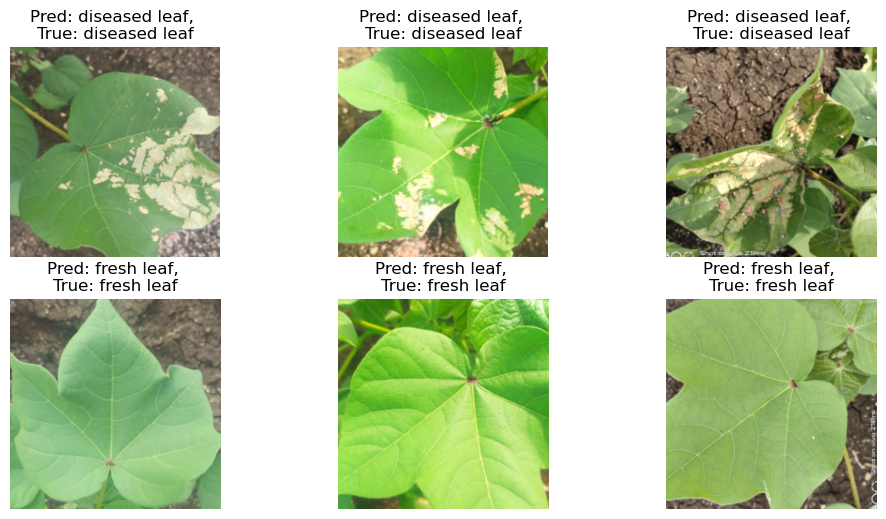

In [13]:
model.load_state_dict(torch.load('best_model.pth'))

# Assuming you have a class_names dictionary
class_names = image_datasets['test'].classes

# Make predictions on the test set
test_predictions, test_true_labels = predict(model, dataloaders['test'])

# Visualize predictions on the test set
visualize_predictions(model, dataloaders['test'], class_names, num_images=6)


In [14]:
def predict_single_image(model, image_path, transform):
    # Set the model to evaluation mode (disables dropout and batch normalization layers)
    model.eval()

    # Load the image from the given path and convert it to RGB format
    image = Image.open(image_path).convert('RGB')
    # Apply the transformation pipeline to preprocess the image (e.g., resizing, normalization)
    input_tensor = transform(image)
    # Add a batch dimension to the tensor (models expect input in batches)
    input_batch = input_tensor.unsqueeze(0)

    # Move the input tensor to the appropriate device (GPU)
    input_batch = input_batch.to(device)

    # Disable gradient calculation for inference to save memory and computations
    with torch.no_grad():
        # Perform a forward pass through the model to get the output
        output = model(input_batch)
        # Round the output to get a binary prediction (0 or 1)
        pred = torch.round(output)
        # Apply the sigmoid function to get a probability score between 0 and 1
        probability = torch.sigmoid(output)  # Necessary if the model's last layer doesn't include sigmoid

    # Return the probability as a scalar and the predicted label as an integer
    return probability.item(), int(pred.item())

def visualize_single_image_prediction(model, image_path, transform, class_names):
    # Get the probability and predicted label for the input image
    probability, pred_label = predict_single_image(model, image_path, transform)

    # Load the image again without transformations for visualization
    image = Image.open(image_path).convert('RGB')
    # Create a new figure with specified size
    plt.figure(figsize=(6, 4))
    # Hide axis ticks and labels
    plt.axis('off')
    # Set the title with the predicted class name and probability score
    plt.title(f'Predicted: {class_names[pred_label]} (Prob: {probability:.2f})')
    
    # Display the image
    plt.imshow(image)
    # Show the plot
    plt.show()

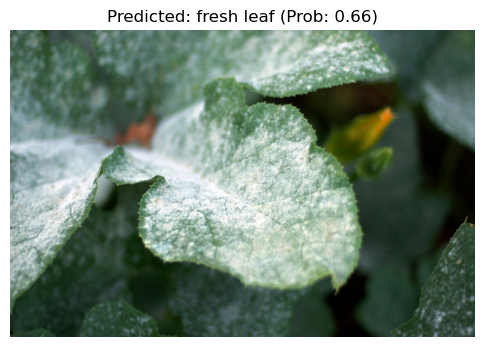

In [15]:
model.load_state_dict(torch.load('best_model.pth'))

# Define the same transformations as used for validation/testing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
class_names = image_datasets['test'].classes

model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.to(device)

image_path = 'test3.jpg'

# Predict and visualize
visualize_single_image_prediction(model, image_path, transform, class_names)
